In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
print(cv2.__version__)

plt.rc('image', cmap='gray') # set the default color-map of plt.image() to 'gray'
plt.rc('figure', figsize=[16,8]) # set a bigger default figure size

4.4.0


Submitted by: [ **Eitan Yakubov** ]

# project - Juggling balls
## Our goals are:
- To Track all 3 balls
- To Overlay trajectories
- To Display the velocity of each ball
- To Plot the velocity of each ball,as a function of time

### These are the functions that we are going to use:

In [2]:
def show_img_in_rgb(img,title):
    img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.show()
    

In [3]:
def show_binary_img(binary_img,title):
    plt.imshow(binary_img)
    plt.title(title)
    plt.show() 

In [4]:
# this function receives a list of contours and returns the right contour of the ball
def find_ball_contour(ctrs):
    #if there is only 1 contour
    if len(ctrs)==1:
        ctr=ctrs[0]
        
        # this contour must be the right contour for the ball
        #because there are no other options
        return ctr 
    
    #we estimate that the area(m00) of the right contour of the ball
    #needs to be in the range of 100-350
    for ctr in ctrs:
        M=cv2.moments(ctr)
        if 350>M["m00"]>100:
            break
        
    return ctr

In [5]:
# this function receives a list of contours and returns the center of the ball
def find_ball_center(ctrs):
    #if there is only 1 contour
    if len(ctrs)==1:
        ctr=ctrs[0]
        (x,y),_=cv2.minEnclosingCircle(ctr)
        center=(int(x),int(y))
        
        #return the center of the ball
        return center
        
    center=0,0
    #we estimate that the radius of the ball
    #must be in the range of 8-15
    for ctr in ctrs:
        (x,y),radius=cv2.minEnclosingCircle(ctr)
        if (radius>=8) and (radius<=15):
            center=(int(x),int(y))
            break
        
    return center
            
    

In [6]:
# this function calculates the velocity of the ball
def calculate_pixels_per_second(distance,fps):
    time=1/fps
    velocity=int(distance/time)
    return velocity

In [7]:
# this function draws line and rectangle near the ball
def draw_line_and_rectangle(frame,canvas,center):
    #unpacking the center of the ball into x and y
    x,y=center
    
    #making points to draw rectangle near the center of the ball
    pts=np.int32([[x+25,y-10],[x+55,y-10],[x+55,y+10],[x+25,y+10]])
    
    #draw a line near the center of the ball
    cv2.line(canvas,(x+10,y),(x+25,y),(0,255,255),1)
    
    #draw the rectangle
    cv2.fillPoly(canvas,[pts],(0,255,255))
    
    #add the line and the rectangle to the frame
    frame[:]=cv2.addWeighted(frame,1,canvas,0.5,0)
    
    #reset canvas for the next iteration
    canvas[:]=0
    
    

In [8]:
def nothing(x):
    pass

# this function can be used for playing with the parameters's values
# of HSV while the video is running to find the best
# combination values for the ball

#cap=the whole video
#low_high_H=array of 2 values:low and high hue
#low_high_S=array of 2 values:low and high saturation
#low_high_V=array of 2 values:low and high value

def show_video_with_trackbar(cap,low_high_H,low_high_S,low_high_V):
    
    cv2.namedWindow('image')

    cv2.createTrackbar('lowH','image',low_high_H[0],180,nothing)#low hue
    cv2.createTrackbar('highH','image',low_high_H[1],180,nothing)#high hue

    cv2.createTrackbar('lowS','image',low_high_S[0],255,nothing)#low saturation
    cv2.createTrackbar('highS','image',low_high_S[1],255,nothing)#high saturation

    cv2.createTrackbar('lowV','image',low_high_V[0],255,nothing)#low value
    cv2.createTrackbar('highV','image',low_high_V[1],255,nothing)#high value

    while True:
        ret, frame = cap.read()
        if ret:
            blur=cv2.GaussianBlur(frame ,(0,0),4)
            frame_hsv=cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
            lowH = cv2.getTrackbarPos('lowH','image')
            highH = cv2.getTrackbarPos('highH','image')
            lowS = cv2.getTrackbarPos('lowS','image')
            highS = cv2.getTrackbarPos('highS','image')
            lowV = cv2.getTrackbarPos('lowV','image')
            highV = cv2.getTrackbarPos('highV','image')
            lower_hsv = np.array([lowH,lowS,lowV])
            higher_hsv = np.array([highH,highS,highV])
            mask = cv2.inRange(frame_hsv,lower_hsv,higher_hsv)

            frame_copy = cv2.bitwise_and(frame,frame,mask=mask)

            cv2.imshow('image', frame_copy)
            k = cv2.waitKey(1) & 0xFF
            if k == 27:
                break
    
        else:
            break
        
    cv2.destroyAllWindows()
    cv2.waitKey(1)


In [9]:
#this function is used for calculating the distance
#between the center of the ball in the previous frame
#to the center of the same ball in the current frame
def euclidean_distance(prev_center,curr_center):
    distance=np.sqrt(np.sum((prev_center-curr_center)**2))
    return distance

## Step 1-Track all 3 balls:
First,we will blur the first frame, convert it from BGR to HSV, and then, we will put to the function "inRange" different parameters' values of HSV for each ball to locate each ball separately. In addition, we will use trackbar in order to find the best combination of parameters' values for each ball.

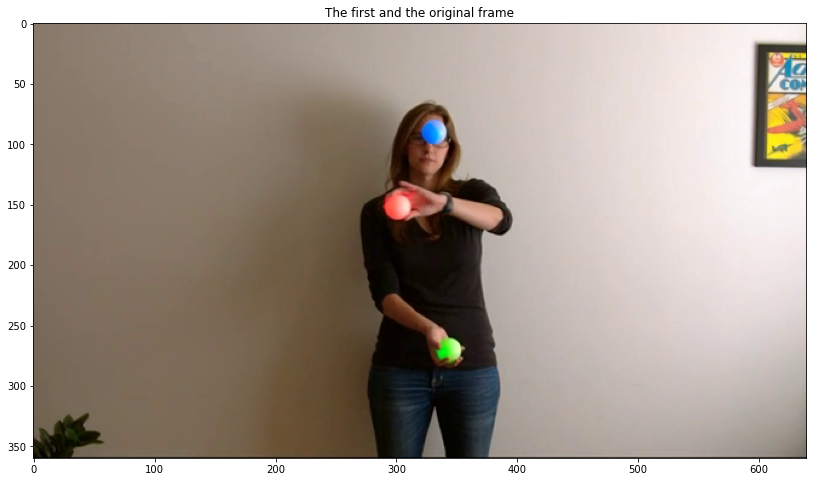

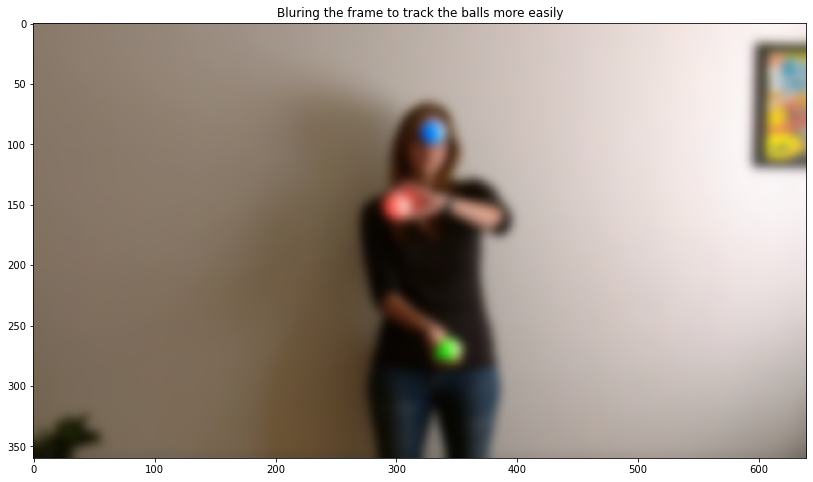

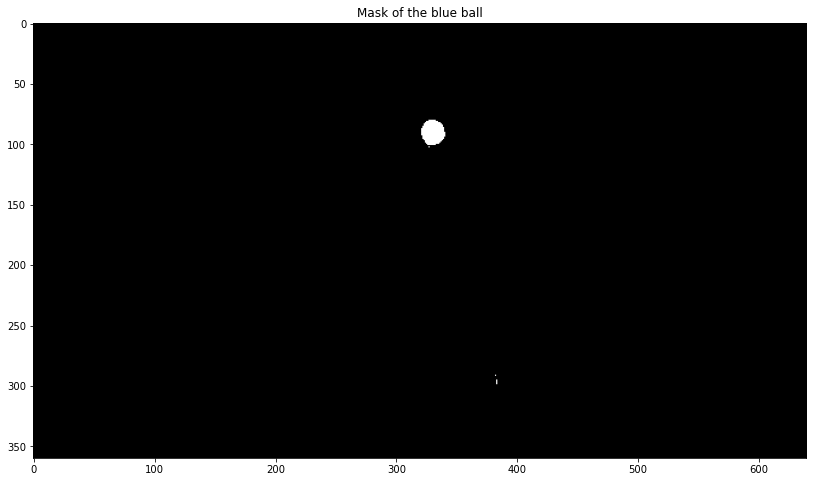

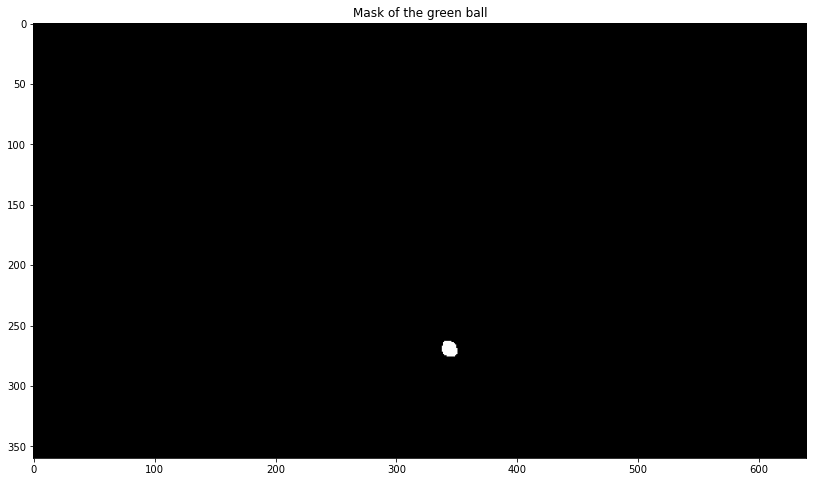

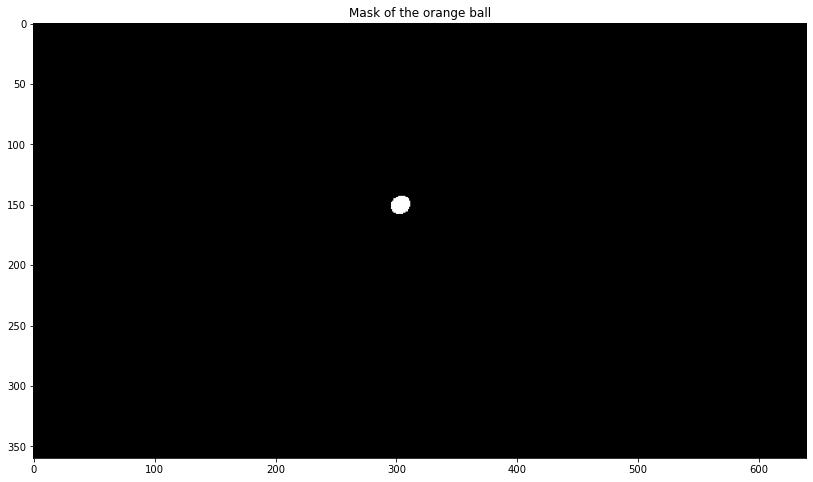

In [10]:
cap1 = cv2.VideoCapture('P4_juggling.mov')

W = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap1.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
new_video = cv2.VideoWriter('juggling balls tracking.mp4',fourcc, FPS, (W,H))

ret, frame = cap1.read()

title="The first and the original frame"
show_img_in_rgb(frame,title)

blur = cv2.GaussianBlur(frame ,(0,0),4)
title="Bluring the frame to track the balls more easily"
show_img_in_rgb(blur,title)

frame_hsv=cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)

# blue ball parameters' values
low_high_H=102,164
low_high_S=56,255
low_high_V=110,255
show_video_with_trackbar(cap1,low_high_H,low_high_S,low_high_V)

#after playing with the parameters' values i decided that
#these values are the right combination for tracking the blue ball
lower = np.array([102,56,110])
higher = np.array([164,255,255])

mask_blue= cv2.inRange(frame_hsv, lower, higher)
title="Mask of the blue ball"
show_binary_img(mask_blue,title)

cap1 = cv2.VideoCapture('P4_juggling.mov')

# green ball parameters' values
low_high_H=30,60
low_high_S=115,255
low_high_V=179,255
show_video_with_trackbar(cap1,low_high_H,low_high_S,low_high_V)

#after playing with the parameters' values i decided that
#these values are the right combination for tracking the green ball
lower = np.array([30,115,179])
higher = np.array([60,255,255])

mask_green = cv2.inRange(frame_hsv, lower, higher)
title="Mask of the green ball"
show_binary_img(mask_green,title)

cap1 = cv2.VideoCapture('P4_juggling.mov')

# orange ball parameters' values
low_high_H=0,7
low_high_S=80,255
low_high_V=223,255
show_video_with_trackbar(cap1,low_high_H,low_high_S,low_high_V)

#after playing with the parameters' values i decided that
#these values are the right combination for tracking the orange ball
lower=np.array([0,80,223])
higher=np.array([7,255,255])

mask_orange = cv2.inRange(frame_hsv, lower, higher)
title="Mask of the orange ball"
show_binary_img(mask_orange,title)

cap1 = cv2.VideoCapture('P4_juggling.mov')
ret, frame = cap1.read()

## Step 1-Track all 3 balls:
Second,we will use the function "findContours" to find optional contours for each ball.
<br>
Then,we will find the right contour for each ball.

In [11]:
#create optional contours for the blue ball
ctrs_blue, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#create optional contours for the green ball
ctrs_green, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#create optional contours for the orange ball
ctrs_orange, _ = cv2.findContours(mask_orange, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print("len(ctrs_blue)=",len(ctrs_blue))
print("optional m00 of contours for blue ball:")
for ctr in ctrs_blue:
    M=cv2.moments(ctr)
    print(M["m00"])
    
print("len(ctrs_green)=",len(ctrs_green))
print("optional m00 of contours for green ball:")
for ctr in ctrs_green:
    M=cv2.moments(ctr)
    print(M["m00"])

print("len(ctrs_orange)=",len(ctrs_orange))
print("optional m00 of contours for orange ball:")
for ctr in ctrs_orange:
    M=cv2.moments(ctr)
    print(M["m00"])

ctr_blue=0
ctr_green=0
ctr_orange=0

#find the right contour for the blue ball
ctr_blue=find_ball_contour(ctrs_blue)

#find the right contour for the green ball
ctr_green=find_ball_contour(ctrs_green)   

#find the right contour for the orange ball
ctr_orange=find_ball_contour(ctrs_orange)
    
M=cv2.moments(ctr_blue)
print("m00 of ctr_blue =",M["m00"])
M=cv2.moments(ctr_green)
print("m00 of ctr_green =",M["m00"])
M=cv2.moments(ctr_orange)
print("m00 of ctr_orange =",M["m00"])


len(ctrs_blue)= 4
optional m00 of contours for blue ball:
0.0
0.0
0.0
299.0
len(ctrs_green)= 1
optional m00 of contours for green ball:
120.5
len(ctrs_orange)= 1
optional m00 of contours for orange ball:
170.0
m00 of ctr_blue = 299.0
m00 of ctr_green = 120.5
m00 of ctr_orange = 170.0


## Step 2-Overlay trajectories:
First, we will use the function "minEnclosingCircle" to get the center and the radius of each ball, draw a circle for each ball and see the results. Then,based on the results, we will estimate the right radius for the balls, draw a circle with this radius for each ball and check the results again. If this radius gives good results, we will draw circles with this radius for the next of the frames.

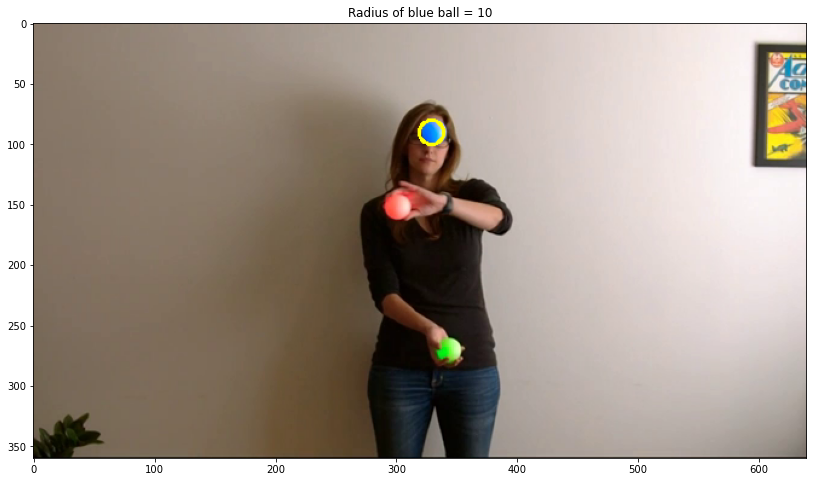

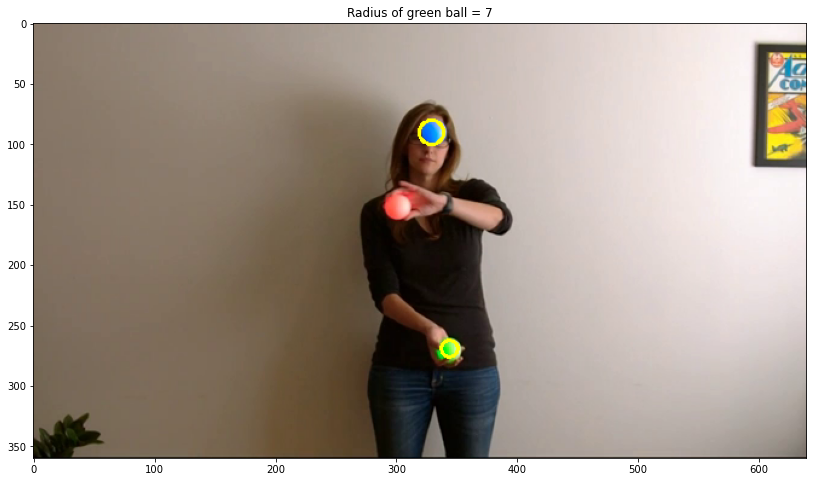

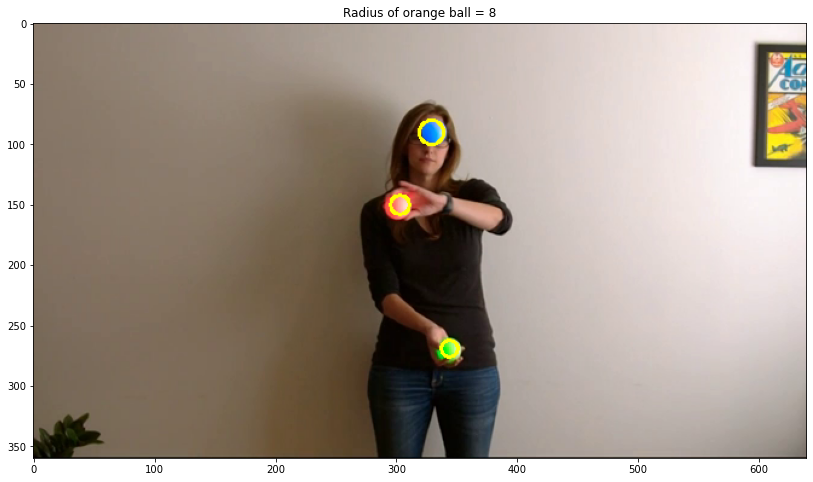

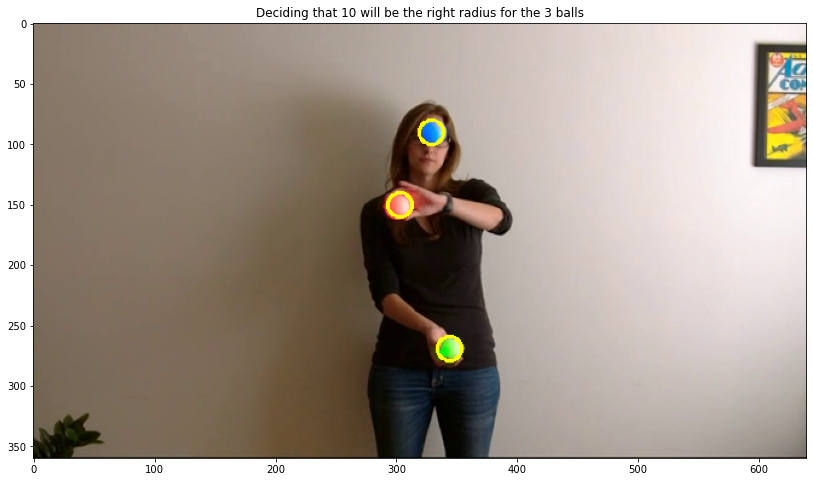

In [12]:
#create an empty dictionary to save the center
#of each ball for the next step
balls_centers={}

#create a copy of the first frame for experimental purposes
frame_copy=frame.copy()

(x,y),radius=cv2.minEnclosingCircle(ctr_blue)
center=(int(x),int(y))

#save the center of the blue ball for the next step
balls_centers["centerOfBlueBall"]=center
radius=int(radius)
cv2.circle(frame_copy,center,radius,(0,255,255),2)
title="Radius of blue ball = "+ str(radius)
show_img_in_rgb(frame_copy,title)

(x,y),radius=cv2.minEnclosingCircle(ctr_green)
center=(int(x),int(y))

#save the center of the green ball for the next step
balls_centers["centerOfGreenBall"]=center
radius=int(radius)
cv2.circle(frame_copy,center,radius,(0,255,255),2)
title="Radius of green ball = "+ str(radius)
show_img_in_rgb(frame_copy,title)

(x,y),radius=cv2.minEnclosingCircle(ctr_orange)
center=(int(x),int(y))

#save the center of the orange ball for the next step
balls_centers["centerOfOrangeBall"]=center
radius=int(radius)
cv2.circle(frame_copy,center,radius,(0,255,255),2)
title="Radius of orange ball = " +str(radius)
show_img_in_rgb(frame_copy,title)

#after the experiment,10 seems to be the right radius for the balls
radius_ball=10
cv2.circle(frame,balls_centers["centerOfBlueBall"],radius_ball,(0,255,255),2)
cv2.circle(frame,balls_centers["centerOfGreenBall"],radius_ball,(0,255,255),2)
cv2.circle(frame,balls_centers["centerOfOrangeBall"],radius_ball,(0,255,255),2)
title="Deciding that 10 will be the right radius for the 3 balls"
show_img_in_rgb(frame,title)

## Step 2-Overlay trajectories:
Second, in each frame we will use the centers of the balls to know their location.
<br>
Then, we will draw a line and rectangle near them in each frame.

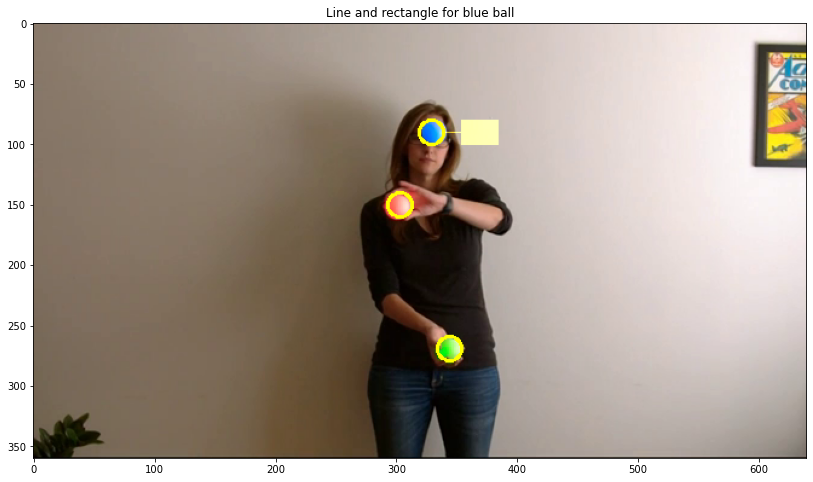

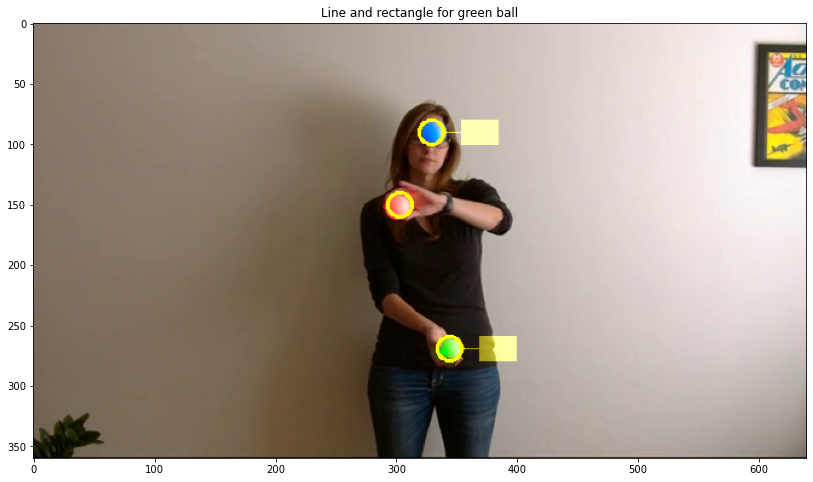

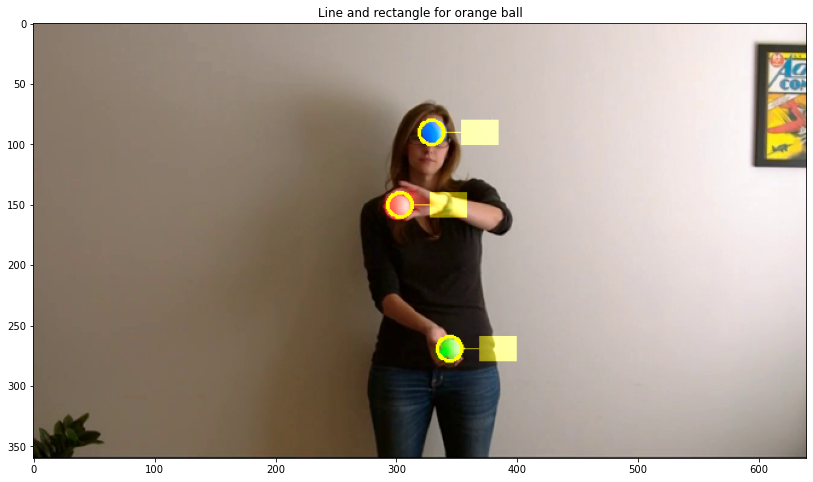

In [13]:
# Create a mask image for drawing purposes
canvas = np.zeros_like(frame)

#get from the dictionary the center of the blue ball
center=balls_centers["centerOfBlueBall"]

#draw a line and rectangle near the center of the blue ball
draw_line_and_rectangle(frame,canvas,center)
title="Line and rectangle for blue ball"
show_img_in_rgb(frame,title)

#get from the dictionary the center of the green ball
center=balls_centers["centerOfGreenBall"]

#draw a line and rectangle near the center of the green ball
draw_line_and_rectangle(frame,canvas,center)
title="Line and rectangle for green ball"
show_img_in_rgb(frame,title)

#get from the dictionary the center of the orange ball
center=balls_centers["centerOfOrangeBall"]

#draw a line and rectangle near the center of the orange ball
draw_line_and_rectangle(frame,canvas,center)
title="Line and rectangle for orange ball"
show_img_in_rgb(frame,title)

new_video.write(frame)

## Step 3-Display the velocity of each ball:
This step also includes step 1 and 2 because in this step we will go over all the frames in the video. In this step, we will track the balls and use their centers to draw line and rectangle near them. Then, we will write their velocity inside their rectangle in each frame.
Note:the velocity of the balls is calculated as pixels per second. In order to calculate their velocity, we will use the Euclidean distance to calculate the distance between the ball in the previous frame to the same ball in the current frame and then we will divide the distance by time(1/fps). In this way, we get the velocity of each ball.

In [14]:
#creating a list of velocities for each ball for the next step
y_blue_ball_velocities=[]
y_green_ball_velocities=[]
y_orange_ball_velocities=[]

#set the balls' centers of the first frame as the previous balls' centers
#this will help us in the next step
prev_balls_centers=balls_centers

font_params = dict(fontFace = cv2.FONT_HERSHEY_PLAIN,
                   fontScale = 1,
                   lineType = 1)
                   
while True:
    ret,frame=cap1.read()
    if ret:
        
        #blur each frame for tracking the balls more easily
        blur = cv2.GaussianBlur(frame ,(0,0),4)
        
        #convert each frame to hsv to use the function "inRange"
        frame_hsv=cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
        
        #parameters' values of hsv for tracking the blue ball
        lower = np.array([102,56,110])
        higher = np.array([164,255,255])
        mask_blue = cv2.inRange(frame_hsv, lower, higher)
        
        #parameters' values of hsv for tracking the green ball
        lower = np.array([30,115,179])
        higher = np.array([60,255,255])
        mask_green = cv2.inRange(frame_hsv, lower, higher)
        
        #parameters' values of hsv for tracking the orange ball
        lower=np.array([0,80,223])
        higher=np.array([7,255,255]) 
        mask_orange = cv2.inRange(frame_hsv, lower, higher)
        
        #find optional contours for each ball
        ctrs_blue, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        ctrs_green, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        ctrs_orange, _ = cv2.findContours(mask_orange, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        #get the center of the blue ball in the current frame
        curr_center=find_ball_center(ctrs_blue)
        
        #draw a circle with the radius that we chose for the balls
        cv2.circle(frame,curr_center,radius_ball,(0,255,255),2) 
        
        #get the center of the blue ball in the previous frame
        prev_center=prev_balls_centers["centerOfBlueBall"]
        
        #calculate the distance between the center of the blue ball in the previous frame
        #to the center of the blue ball in the current frame
        distance=euclidean_distance(np.array(prev_center),np.array(curr_center))
        
        #get the velocity of the blue ball in the current frame
        blue_ball_velocity=calculate_pixels_per_second(distance,FPS)
        
        #save the velocity in a list for the next step
        y_blue_ball_velocities.append(blue_ball_velocity)
        
        #in the dictionary,set the previous center of the blue ball
        #to be the current center for the next frame
        prev_balls_centers["centerOfBlueBall"]=curr_center
        
        #draw a line and rectangle near the current center of the blue ball
        draw_line_and_rectangle(frame,canvas,curr_center)
        
        #unpack the current center of the blue ball as x and y
        x,y=curr_center
        
        #inside the rectangle,write the velocity of
        #the blue ball in the current frame
        cv2.putText(img=frame,text=str(blue_ball_velocity),
                    org=(x+25,y+5),color=(255,0,0),**font_params)
        
        #get the center of the green ball in the current frame
        curr_center=find_ball_center(ctrs_green)
        
        #draw a circle with the radius that we chose for the balls
        cv2.circle(frame,curr_center,radius_ball,(0,255,255),2) 
        
        #get the center of the green ball in the previous frame
        prev_center=prev_balls_centers["centerOfGreenBall"]   
        
        #calculate the distance between the center of the green ball in the previous frame
        #to the center of the green ball in the current frame
        distance=euclidean_distance(np.array(prev_center),np.array(curr_center))
        
        #get the velocity of the green ball in the current frame
        green_ball_velocity=calculate_pixels_per_second(distance,FPS)
        
        #save the velocity of the ball in a list for the next step
        y_green_ball_velocities.append(green_ball_velocity)
        
        #in the dictionary,set the previous center of the green ball
        #to be the current center for the next frame
        prev_balls_centers["centerOfGreenBall"]=curr_center
        
        #draw a line and rectangle near the current center of the green ball
        draw_line_and_rectangle(frame,canvas,curr_center)
        
        #unpack the current center of the green ball as x and y
        x,y=curr_center
        
        #inside the rectangle,write the velocity of
        #the green ball in the current frame
        cv2.putText(img=frame,text=str(green_ball_velocity),
                    org=(x+25,y+5),color=(0,255,0),**font_params)
        
        #get the center of the orange ball in the current frame
        curr_center=find_ball_center(ctrs_orange)
        
        #draw a circle with the radius that we chose for the balls
        cv2.circle(frame,curr_center,radius_ball,(0,255,255),2) 
        
        #get the center of the orange ball in the previous frame
        prev_center=prev_balls_centers["centerOfOrangeBall"]
        
        #calculate the distance between the center of the orange ball in the previous frame
        #to the center of the orange ball in the current frame
        distance=euclidean_distance(np.array(prev_center),np.array(curr_center))
        
        #get the velocity of the orange ball in the current frame
        orange_ball_velocity=calculate_pixels_per_second(distance,FPS)
        
        #save the velocity of the ball in a list for the next step
        y_orange_ball_velocities.append(orange_ball_velocity)
        
        #in the dictionary,set the previous center of the orange ball
        #to be the current center for the next frame
        prev_balls_centers["centerOfOrangeBall"]=curr_center
        
        #draw a line and rectangle near the current center of the orange ball
        draw_line_and_rectangle(frame,canvas,curr_center)
        
        #unpack the current center of the orange ball as x and y
        x,y=curr_center
        
        #inside the rectangle,write the velocity of
        #the orange ball in the current frame
        cv2.putText(img=frame,text=str(orange_ball_velocity),
                    org=(x+25,y+5),color=(0,0,255),**font_params)
        
        
        new_video.write(frame)
        
        
    else:
        break
        
cap1.release()
new_video.release()


## Step 4-Plot the velocity of each ball,as a function of time:
First, we will use the function "copyMakeBorder" to add a black board in the left side of each frame. On this board, we will draw the graphs of the balls. Then, we will use the function "linspace" to make an equal partition of values that will express the time. After that, we will combine the time's values with the velocity's values of each ball to make points for each ball. Meaning, the time's values will be the X values and the velocity's values will be the Y values. Finally, we will use the points to draw the graphs of the balls.
<br>
Note:In order to seperate the graphs from each other, we will divide the board into 3 equal parts when each part has one graph. More details on the partition:the height of each frame is 360. Therefore, the height of each graph will be 120. In this way, we will make an equal partition of the graphs on the board.

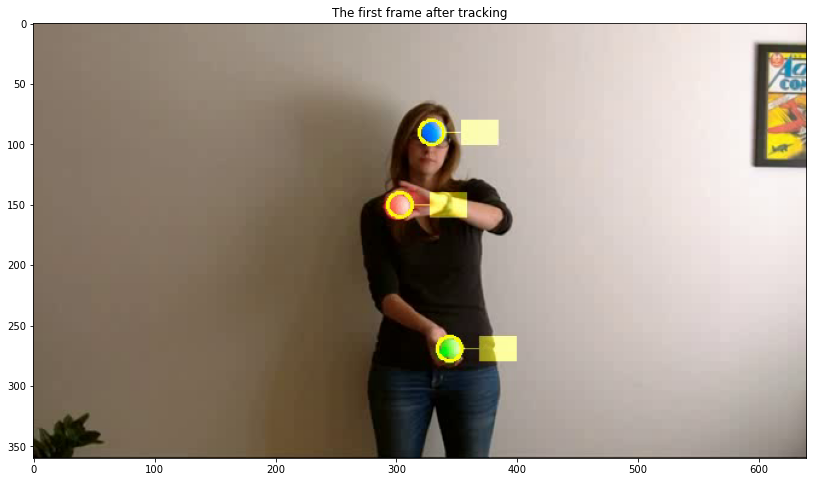

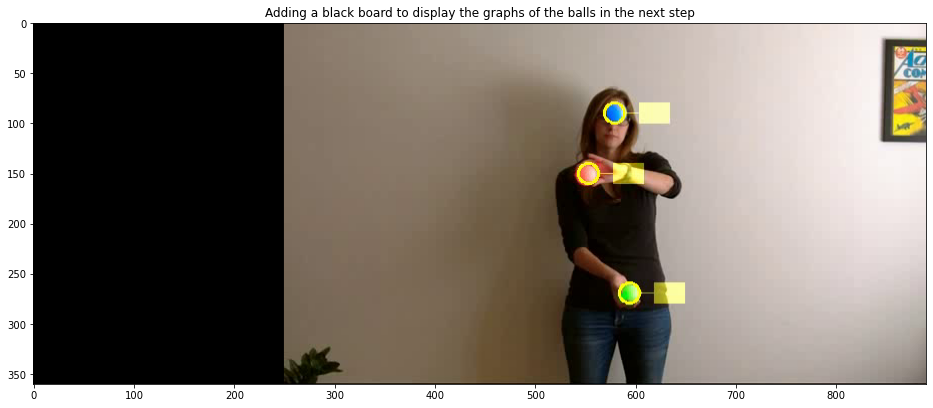

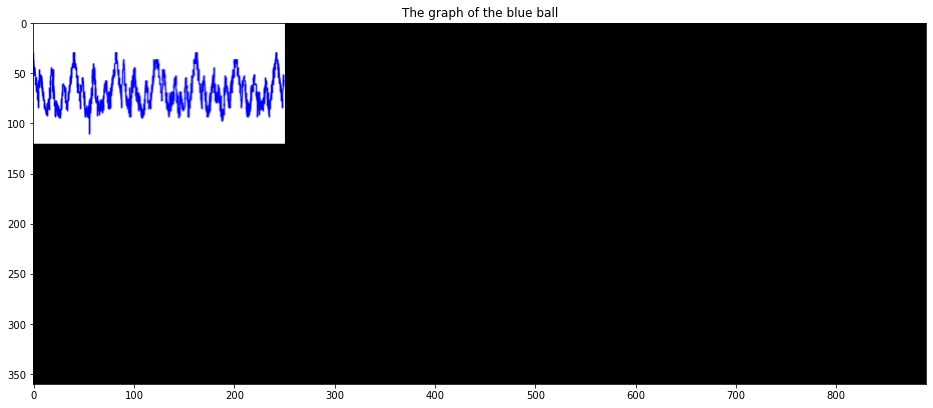

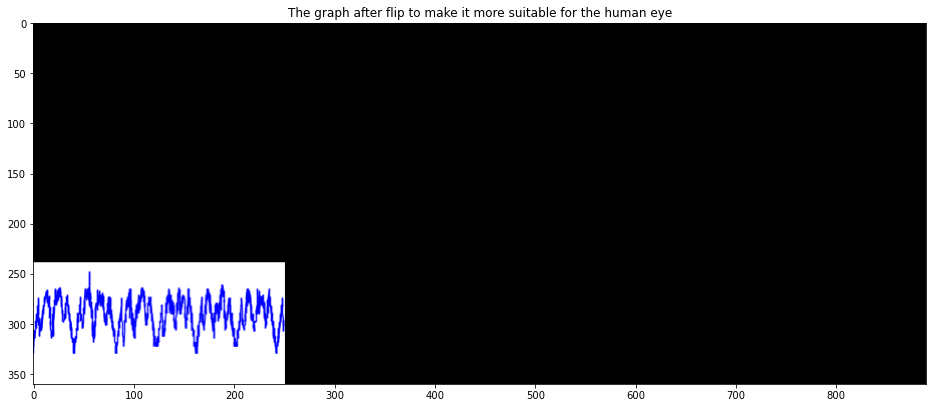

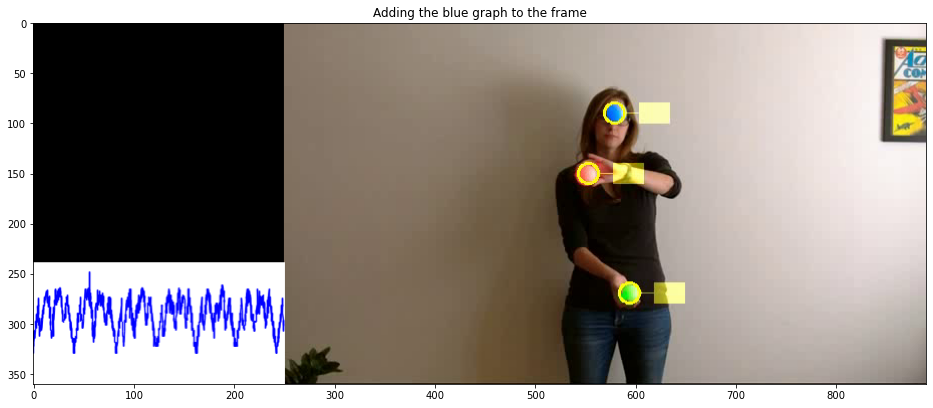

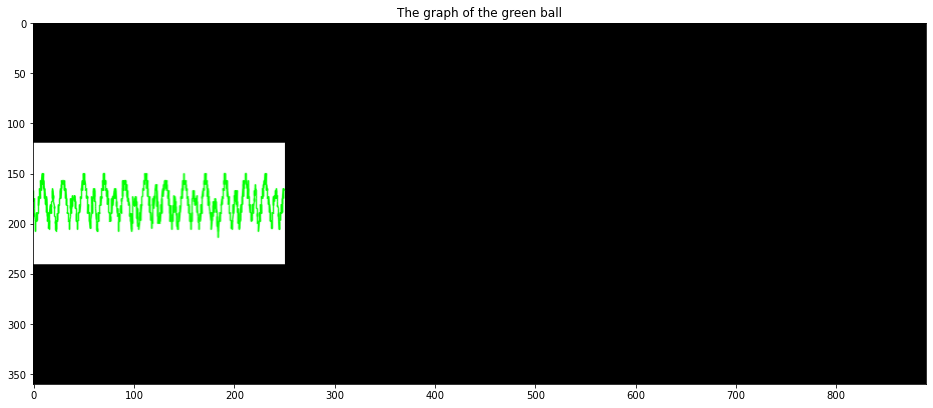

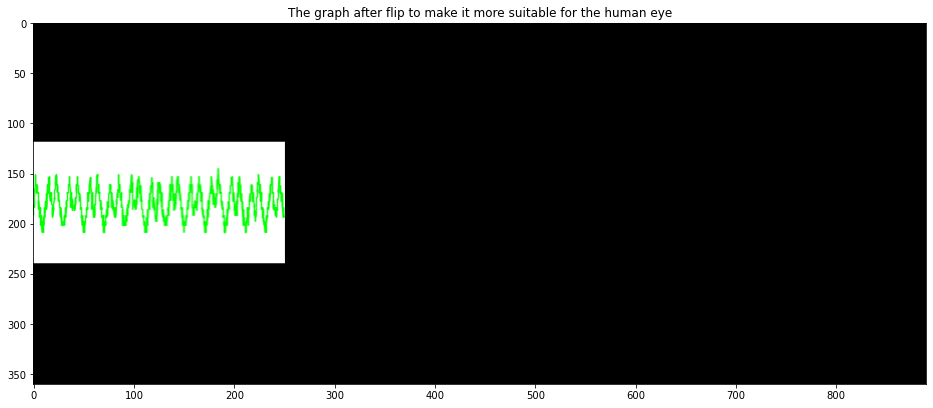

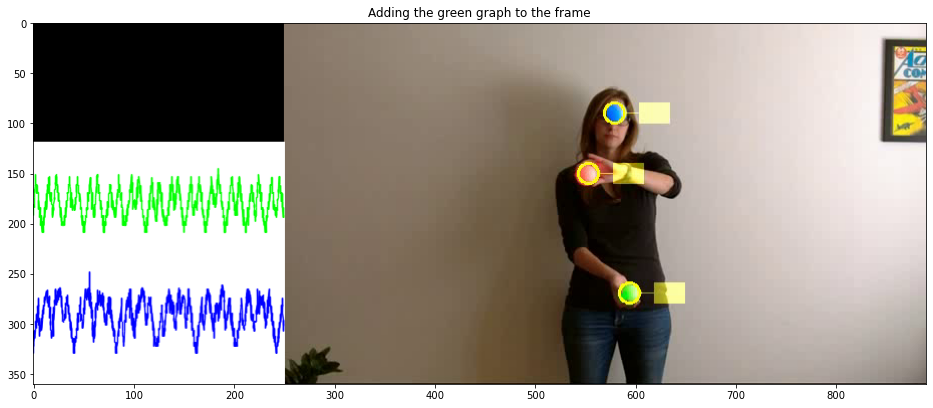

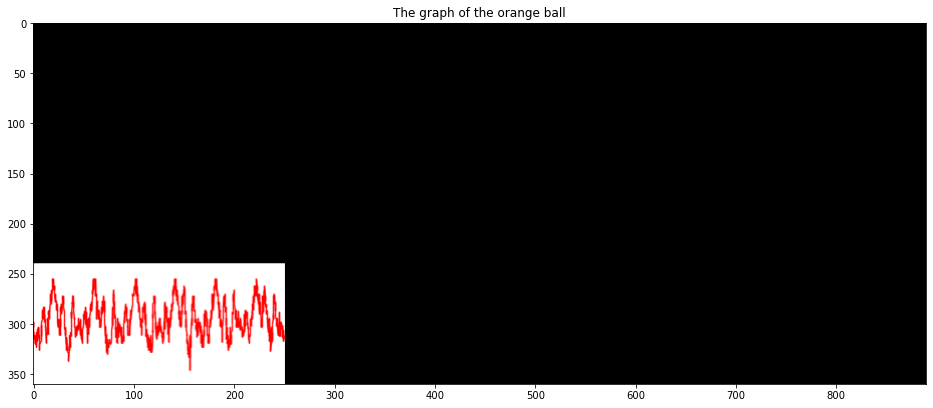

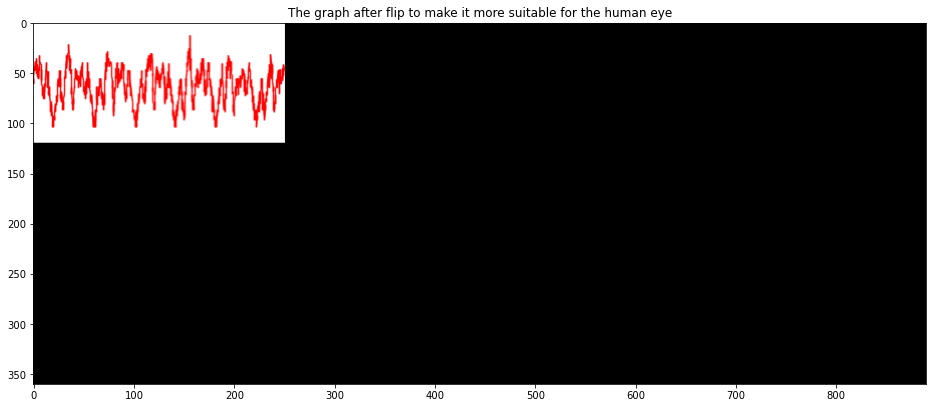

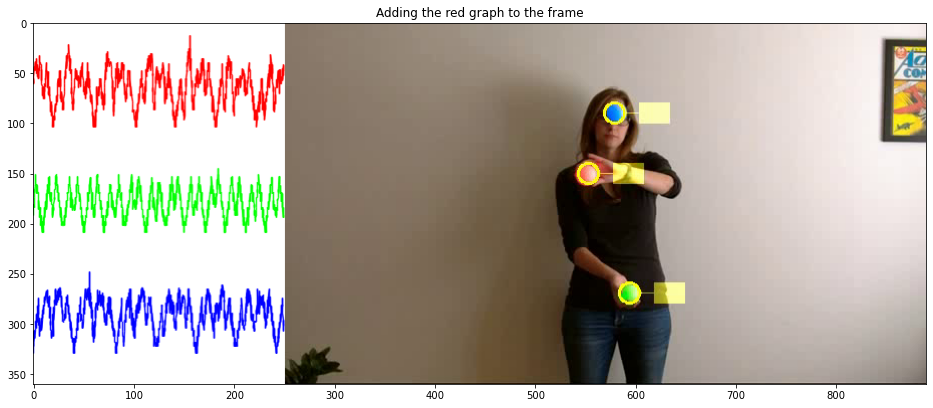

These are 3 examples of frames of the final product:


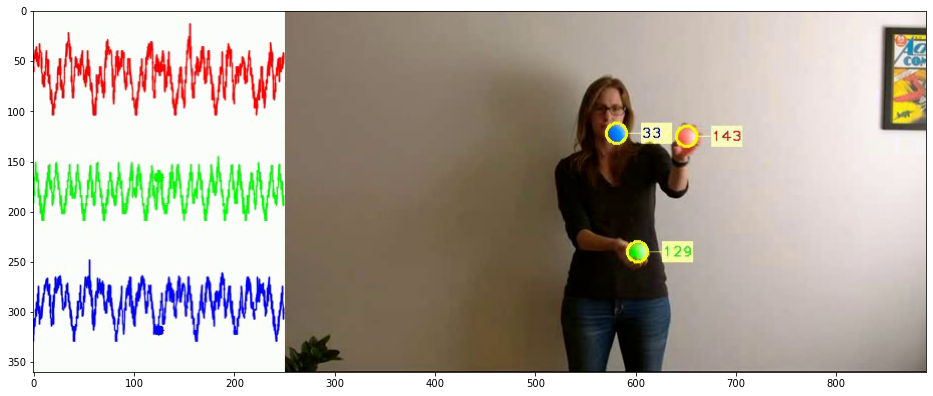

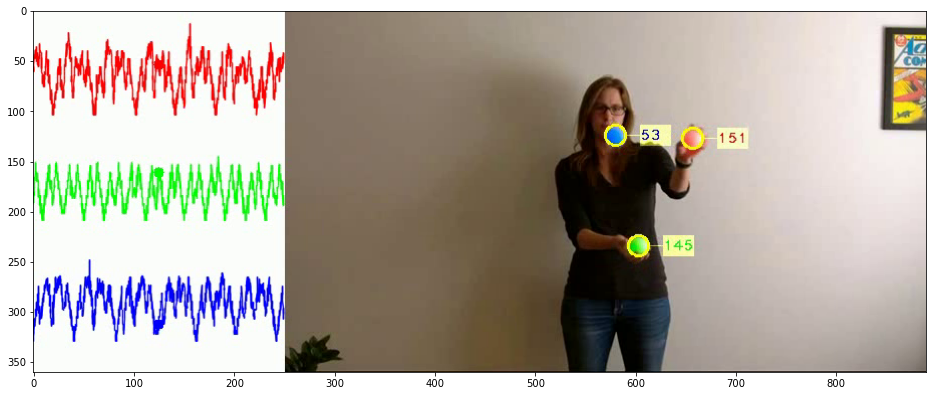

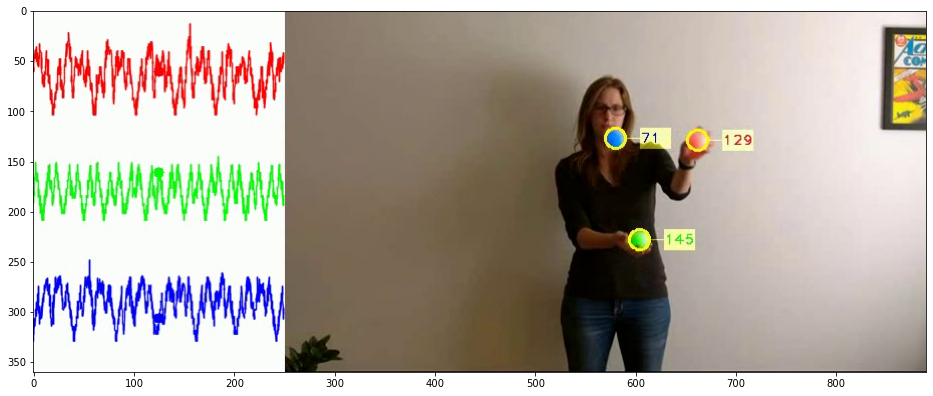

In [15]:
cap2=cv2.VideoCapture('juggling balls tracking.mp4')
ret,frame=cap2.read()

title="The first frame after tracking"
show_img_in_rgb(frame,title)

frame = cv2.copyMakeBorder(src=frame,top=None,bottom=None,left=250,
                           right=None,borderType=cv2.BORDER_CONSTANT)

title="Adding a black board to display the graphs of the balls in the next step"
show_img_in_rgb(frame,title)

W+=250
final_video = cv2.VideoWriter('Juggling balls tracking-final.mp4',fourcc, FPS, (W,H))

num_of_frames_minus1=len(y_blue_ball_velocities)

#make an equal partition of values that will express the time
x_time=np.linspace(0,250,num_of_frames_minus1)

#now,we will divide the board into 3 equal parts when each part has one graph

graph_blue_ball=np.zeros_like(frame)

#part 1 for the blue graph-set the height of the blue graph not to exceed 120
graph_blue_ball[0:121,0:251]=255

y_blue_ball_velocities=np.array(y_blue_ball_velocities)

#divide all velocities' values by 3 so that the height of the graph won't exceed 120
#and add to them the value 30 just to move the graph up a little
#for a nicer visualization
y_blue_ball_velocities=(y_blue_ball_velocities//3)+30

#make points for the blue graph
pts_blue_ball=np.int32(np.vstack((x_time,y_blue_ball_velocities)).T)

#use the points for drawing the blue graph
cv2.polylines(img=graph_blue_ball,pts=[pts_blue_ball],color=(255,0,0)
                      ,isClosed=False,thickness=1,lineType=cv2.LINE_AA)

title="The graph of the blue ball"
show_img_in_rgb(graph_blue_ball,title)

#we flipped the graph so that the greater velocities' values will be more up
#and the smaller ones will be more down on the graph
#this method will be more convenient for the human eye
graph_blue_ball=cv2.flip(graph_blue_ball,0)
title="The graph after flip to make it more suitable for the human eye"
show_img_in_rgb(graph_blue_ball,title)

frame=np.maximum(frame,graph_blue_ball)
title="Adding the blue graph to the frame"
show_img_in_rgb(frame,title)

graph_green_ball=np.zeros_like(frame)

#part 2 for the green graph-set the height of the green graph not to exceed 120
graph_green_ball[120:241,0:251]=255

y_green_ball_velocities=np.array(y_green_ball_velocities)

#divide all velocities' values by 3 so that the height of the graph won't exceed 120
#add to them the value 120 so that the graph will be in the right part of the board(part 2) 
#and also add to them the value 30 just to move the graph up a little
#for a nicer visualization
y_green_ball_velocities=(y_green_ball_velocities//3)+150

#make points for the green graph
pts_green_ball=np.int32(np.vstack((x_time,y_green_ball_velocities)).T)

#use the points for drawing the green graph
cv2.polylines(img=graph_green_ball,pts=[pts_green_ball],color=(0,255,0)
                      ,isClosed=False,thickness=1,lineType=cv2.LINE_AA)

title="The graph of the green ball"
show_img_in_rgb(graph_green_ball,title)

#we flipped the graph so that the greater velocities' values will be more up
#and the smaller ones will be more down on the graph
#this method will be more convenient for the human eye
graph_green_ball=cv2.flip(graph_green_ball,0)
title="The graph after flip to make it more suitable for the human eye"
show_img_in_rgb(graph_green_ball,title)

frame=np.maximum(frame,graph_green_ball)
title="Adding the green graph to the frame"
show_img_in_rgb(frame,title)

graph_orange_ball=np.zeros_like(frame)

#part 3 for the red graph-set the height of the red graph not to exceed 120
graph_orange_ball[240:361,0:251]=255

y_orange_ball_velocities=np.array(y_orange_ball_velocities)

#divide all velocities' values by 3 so that the height of the graph won't exceed 120
#add to them the value 240 so that the graph will be in the right part of the board(part 3) 
#and also add to them the value 15(not 30) just to move the graph up a little
#for a nicer visualization
y_orange_ball_velocities=(y_orange_ball_velocities//3)+255

#make points for the red graph
pts_orange_ball=np.int32(np.vstack((x_time,y_orange_ball_velocities)).T)

#use the points for drawing the red graph
cv2.polylines(img=graph_orange_ball,pts=[pts_orange_ball],color=(0,0,255)
                      ,isClosed=False,thickness=1,lineType=cv2.LINE_AA)

title="The graph of the orange ball"
show_img_in_rgb(graph_orange_ball,title)

#we flipped the graph so that the greater velocities' values will be more up
#and the smaller ones will be more down on the graph
#this method will be more convenient for the human eye
graph_orange_ball=cv2.flip(graph_orange_ball,0)
title="The graph after flip to make it more suitable for the human eye"
show_img_in_rgb(graph_orange_ball,title)

frame=np.maximum(frame,graph_orange_ball)
title="Adding the red graph to the frame"
show_img_in_rgb(frame,title)

final_video.write(frame)

i=0
graph_blue_ball=cv2.flip(graph_blue_ball,0)
graph_green_ball=cv2.flip(graph_green_ball,0)
graph_orange_ball=cv2.flip(graph_orange_ball,0)
while True:
    ret,frame=cap2.read()
    if ret:
        
        frame = cv2.copyMakeBorder(src=frame,top=None,bottom=None,left=250,
                           right=None,borderType=cv2.BORDER_CONSTANT)
        
        graph_temp=graph_blue_ball.copy()
        
        #draw on the blue graph a point that shows the current location of the blue ball
        cv2.circle(graph_temp,tuple(pts_blue_ball[i]),5,(255,0,0),-1)
        graph_temp=cv2.flip(graph_temp,0)
        
        #add the blue graph with the current location to the frame
        frame=np.maximum(frame,graph_temp)
        
        graph_temp=graph_green_ball.copy()
        
        #draw on the green graph a point that shows the current location of the green ball
        cv2.circle(graph_temp,tuple(pts_green_ball[i]),5,(0,255,0),-1)
        graph_temp=cv2.flip(graph_temp,0)
        
        #add the green graph with the current location to the frame
        frame=np.maximum(frame,graph_temp)
        
        graph_temp=graph_orange_ball.copy()
        
        #draw on the red graph a point that shows the current location of the orange ball
        cv2.circle(graph_temp,tuple(pts_orange_ball[i]),5,(0,0,255),-1)
        graph_temp=cv2.flip(graph_temp,0)
        
        #add the red graph with the current location to the frame
        frame=np.maximum(frame,graph_temp)
        
        final_video.write(frame)
        i+=1
          
    else:
        break

cap2.release()
final_video.release()

cap3=cv2.VideoCapture('Juggling balls tracking-final.mp4')

for _ in range(649):
    ret,frame=cap3.read()

print("These are 3 examples of frames of the final product:")    
title=None    
for _ in range(3):
    ret,frame=cap3.read()
    show_img_in_rgb(frame,title)
    
cap3.release()



